In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import torchvision.utils as vutils
import random
from torch.autograd import Variable
import os
from torch.autograd import Function
from sklearn.manifold import TSNE
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
batch_size = 100

lr = 2e-4

momentum = 0.9

device = "cuda:1" if torch.cuda.is_available() else "cpu"

### Loading Data

In [3]:
class digitData(Dataset):
    def __init__(self, dir, transform, csv):
        imgs = []
        img_list = os.listdir(dir)
        img_list.sort()
        df = pd.read_csv(csv)
        labels = df.to_dict("list")["label"]
        for i in img_list:
            loc = os.path.join(dir, i)
            img = image.imread(loc)
            if len(img.shape) == 2:
                img = np.stack((img,)*3, axis=-1)
            imgs.append(img)
        self.images =  np.array(imgs)
        self.labels = np.array(labels)
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.images)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# 3 x 28 x 28
train_data_dir = "./hw2_data/digits/mnistm/train"
train_csv_dir = "./hw2_data/digits/mnistm/train.csv"
test_data_dir = "./hw2_data/digits/mnistm/test"
test_csv_dir = "./hw2_data/digits/mnistm/test.csv"
train_mnist = digitData(train_data_dir, transform, train_csv_dir)
test_minist = digitData(test_data_dir, transform, test_csv_dir)
train_dl_mnist = DataLoader(train_mnist, batch_size, num_workers=2)
test_dl_mnist = DataLoader(test_minist, batch_size, num_workers=2)

In [5]:
# 3 x 28 x 28
train_data_dir = "./hw2_data/digits/svhn/train"
train_csv_dir = "./hw2_data/digits/svhn/train.csv"
test_data_dir = "./hw2_data/digits/svhn/test"
test_csv_dir = "./hw2_data/digits/svhn/test.csv"
train_svhn = digitData(train_data_dir, transform, train_csv_dir)
test_svhn = digitData(test_data_dir, transform, test_csv_dir)
train_dl_svhn = DataLoader(train_svhn, batch_size, num_workers=2)
test_dl_svhn = DataLoader(test_svhn, batch_size, num_workers=2)

In [6]:
# 1 x 28 x 28 => convert it to 3 channel 3 x 28 x 28
train_data_dir = "./hw2_data/digits/usps/train"
train_csv_dir = "./hw2_data/digits/usps/train.csv"
test_data_dir = "./hw2_data/digits/usps/test"
test_csv_dir = "./hw2_data/digits/usps/test.csv"
train_usps = digitData(train_data_dir, transform, train_csv_dir)
test_usps = digitData(test_data_dir, transform, test_csv_dir)
train_dl_usps = DataLoader(train_usps, batch_size, num_workers=2)
test_dl_usps = DataLoader(test_usps, batch_size, num_workers=2)

In [7]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [8]:
class dann(nn.Module):
    
    def __init__(self):
        super(dann, self).__init__()
        
        self.latent_space = None
        
        # feature extractor
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(3, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(32, 48, 5),
            nn.BatchNorm2d(48),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2, stride=2)
        )
        
        # classifier
        self.fc1 = nn.Sequential(
            nn.Linear(4800, 2400),
            nn.BatchNorm1d(2400),
            nn.ReLU(True),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2400, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
        )
        self.class_classifer = nn.Sequential(
            nn.Linear(100, 10),
            nn.ReLU(True),
        )
        self.softmax = nn.Softmax()
        
        # domain classifier
        self.d_fc1 = nn.Sequential(
            nn.Linear(4800, 100),
            nn.ReLU(True),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(100, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x, alpha):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 4800)
        self.latent_space = x
        reverse_feature = ReverseLayerF.apply(x, alpha)
        x = self.fc1(x)
        x = self.fc2(x)
        class_output = self.class_classifer(x)
        x = self.d_fc1(reverse_feature)
        domain_output = self.domain_classifier(x)
        return class_output, domain_output
    
    def get_latent(self):
        return self.latent_space

In [ ]:
def train_model(source_dl, target_dl, model, adv_loss, aux_loss, optimizer, epoch, gap):
    running_loss = 0
    run_class_loss = 0
    run_domain_loss = 0
    model.train()
    for batch, (source, target) in enumerate(zip(source_dl, target_dl), 0):
        # data prep
        source_img, source_lb = source
        target_img, target_lb = target
        source_img = source_img.to(device)
        source_lb = source_lb.to(device)
        target_img = target_img.to(device)
        target_lb = target_lb.to(device)
        
        source_size = source_lb.shape[0]
        target_size = target_lb.shape[0]
        
        source_domain_lb = torch.zeros(source_size).type(torch.FloatTensor).to(device)
        target_domain_lb = torch.ones(target_size).type(torch.FloatTensor).to(device)
        
        model.zero_grad()
        constant = alpha = 0.25
        scr_classes, scr_domains = model(source_img, alpha)
        trg_classes, trg_domains = model(target_img, alpha)
        scr_domains = scr_domains.view(source_size)
        trg_domains = trg_domains.view(target_size)
        # class loss
        class_loss = auxiliary_loss(scr_classes, source_lb)
        run_class_loss += class_loss
        
        #domain loss
        source_domain_loss = adversarial_loss(scr_domains, source_domain_lb)
        target_domain_loss = adversarial_loss(trg_domains, target_domain_lb)
        domain_loss = target_domain_loss + source_domain_loss
        run_domain_loss += domain_loss
        loss = class_loss + constant * domain_loss
        loss.backward()
        optimizer.step()
        
        scr_classes = scr_classes.cpu().detach().numpy()
        source_lb = source_lb.cpu().detach().numpy()
        trg_classes = trg_classes.cpu().detach().numpy()
        target_lb = target_lb.cpu().detach().numpy()
        scr_domains = scr_domains.cpu().detach().numpy()
        trg_domains = trg_domains.cpu().detach().numpy()
        
        # accuracy calculation
        source_class_acc = np.mean(np.argmax(scr_classes, axis=1) == source_lb)
        target_class_acc = np.mean(np.argmax(trg_classes, axis=1) == target_lb)
        source_domain_acc = np.mean(np.around(scr_domains) == 0)
        target_domain_acc = np.mean(np.around(trg_domains) == 1)
        
        # train with data 
        running_loss += loss.item()
        if (batch+1) % gap == 0:
            loss, current = loss.item(), batch * len(source_img) + batch_size
            print(f"loss: {loss:.5f} class_loss: {run_class_loss:.5f} domain_loss: {run_domain_loss:.5f}")
            print(f"scr_class_accuracy:{source_class_acc * 100:.0f}% trg_class_accuracy:{target_class_acc * 100:.0f}% scr_domain_accuracy:{source_domain_acc * 100:.0f}% trg_domain_accuracy:{target_domain_acc * 100:.0f}% [{current:>5d}]")
            run_class_loss = 0
            run_domain_loss = 0
            running_loss = 0
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_model(train_dl_svhn, train_dl_mnist, model, adversarial_loss, 
#                 auxiliary_loss, optimizer, t, 200)

In [16]:
def test(model, source_dl, target_dl, alpha):
    model.eval()
    total_scr_classes = torch.FloatTensor().to(device)
    total_trg_classes = torch.FloatTensor().to(device)
    total_scr_domains = torch.FloatTensor().to(device)
    total_trg_domains = torch.FloatTensor().to(device)
    total_scr_lb = torch.FloatTensor().to(device)
    total_trg_lb = torch.FloatTensor().to(device)
    for batch, (source, target) in enumerate(zip(source_dl, target_dl), 0):
        # data prep
        source_img, source_lb = source
        target_img, target_lb = target
        source_img = source_img.to(device)
        source_lb = source_lb.to(device)
        target_img = target_img.to(device)
        target_lb = target_lb.to(device)
        
        source_size = source_lb.shape[0]
        target_size = target_lb.shape[0]
        
        # feeed in the input
        batch_size = source_lb.size(0)
        scr_classes, scr_domains = model(source_img, alpha)
        trg_classes, trg_domains = model(target_img, alpha)
        scr_domains = scr_domains.view(source_size)
        trg_domains = trg_domains.view(target_size)
        
        total_scr_classes = torch.cat((total_scr_classes, scr_classes))
        total_trg_classes = torch.cat((total_trg_classes, trg_classes))
        total_scr_domains = torch.cat((total_scr_domains, scr_domains))
        total_trg_domains = torch.cat((total_trg_domains, trg_domains))
        total_scr_lb = torch.cat((total_scr_lb, source_lb))
        total_trg_lb = torch.cat((total_trg_lb, target_lb))
        
    total_scr_classes = total_scr_classes.cpu().detach().numpy()
    total_trg_classes = total_trg_classes.cpu().detach().numpy()
    total_scr_lb = total_scr_lb.cpu().detach().numpy()
    total_trg_lb = total_trg_lb.cpu().detach().numpy()
    total_scr_domains = total_scr_domains.cpu().detach().numpy()
    total_trg_domains = total_trg_domains.cpu().detach().numpy()
    
    # accuracy calculation
    source_class_acc = np.mean(np.argmax(total_scr_classes, axis=1) == total_scr_lb)
    # size is different so we can't use that way
    target_class_acc = np.mean(np.argmax(total_trg_classes, axis=1) == total_trg_lb)
    source_domain_acc = np.mean(np.around(total_scr_domains) == 0)
    target_domain_acc = np.mean(np.around(total_trg_domains) == 1)
    
    print(f"scr_class_accuracy:{source_class_acc * 100:.2f}% trg_class_accuracy:{target_class_acc * 100:.2f}% scr_domain_accuracy:{source_domain_acc * 100:.1f}% trg_domain_accuracy:{target_domain_acc * 100:.1f}%")
# test(model, test_dl_svhn, test_dl_mnist, 0.25)

In [25]:
def get_feature(model, val_dl, alpha):
    model.eval()
    model.to(device)
    features = torch.FloatTensor().to(device)
    cls_pred = torch.FloatTensor().to(device)
    dm_pred = torch.FloatTensor().to(device)
    count = 0
    for batch, data in enumerate(val_dl, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        
        class_output, domain_output = model(images, alpha)
        feature_b = model.get_latent()

        
        class_output = torch.argmax(class_output, dim=1)
        
        features = torch.cat((features, feature_b))
        # modified to real label instead of predicted label
        cls_pred = torch.cat((cls_pred, labels))
        dm_pred =  torch.cat((dm_pred, domain_output))
        count += 1
        if count == 4:
            break
    features = features.cpu().detach().numpy()
    cls_pred = cls_pred.cpu().detach().numpy()
    dm_pred = dm_pred.cpu().detach().numpy()
    
    return features, cls_pred, dm_pred

In [11]:
def show_tsne_cls(features, pred):
    def scale_to_01_range(x):
        value_range = (np.max(x) - np.min(x))
        # distribution range
        starts_from_zero = x - np.min(x)
        # move the distribution so it starts from zero
        return starts_from_zero / value_range
    
    # create tsne
    tsne = TSNE(n_components=2).fit_transform(features)
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    
    # scale the plot to the range 0-1
#     tx = scale_to_01_range(tx)
#     ty = scale_to_01_range(ty)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    colors = ['black', 'blue', 'purple', 'yellow', 'red', 'lime', 'cyan', 'white', 'orange', 'gray']
    count = 0
    
    for i in range(len(pred)):
        if pred[i] < 10:
            count += 1
            current_tx = np.take(tx, i)
            current_ty = np.take(ty, i)
            ax.scatter(current_tx, current_ty, c=colors[int(pred[i])])
    print(count)

    ax.legend(loc='best')
    plt.show()

In [12]:
def show_tsne_domain(src_feature, trg_feature):
    
    src_tsne = TSNE(n_components=2).fit_transform(src_feature)
    trg_tsne = TSNE(n_components=2).fit_transform(trg_feature)
    
    src_tx = src_tsne[:, 0]
    src_ty = src_tsne[:, 1]
    
    trg_tx = trg_tsne[:, 0]
    trg_ty = trg_tsne[:, 1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    colors = ['blue', 'red']
    count = 0
    print("blue represent source domain / red represent target domain")
    for i in range(len(src_feature)):
        count += 1
        current_tx = np.take(src_tx, i)
        current_ty = np.take(src_ty, i)
        ax.scatter(current_tx, current_ty, c=colors[0])
        current_tx = np.take(trg_tx, i)
        current_ty = np.take(trg_ty, i)
        ax.scatter(current_tx, current_ty, c=colors[1])
        
    print(count)

    ax.legend(loc='best')
    plt.show()

Source Domain: svhn / Target Domain: mnist

In [13]:
device = "cuda:1"

In [14]:
model_s_to_m = dann().to(device)
model_s_to_m.load_state_dict(torch.load("./check_point/dann_s_to_m.pth"))
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_s_to_m.parameters(), lr=lr, momentum = momentum)

In [ ]:
epochs = 20
gap = 200 # gap of batch between output
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_model(train_dl_svhn, train_dl_mnist, model_s_to_m, adversarial_loss, 
                auxiliary_loss, optimizer, t, gap)

In [17]:
test(model_s_to_m, test_dl_svhn, test_dl_mnist, 0.25)

scr_class_accuracy:85.05% trg_class_accuracy:51.26% scr_domain_accuracy:76.1% trg_domain_accuracy:86.6%


In [ ]:
torch.save(model_s_to_m.state_dict(), "./check_point/dann_s_to_m.pth")

In [26]:
alpha = 0.25
src_features, src_cls_pred, src_dm_pred = get_feature(model_s_to_m, test_dl_svhn, alpha)
trg_features, trg_cls_pred, trg_dm_pred = get_feature(model_s_to_m, test_dl_mnist, alpha)

No handles with labels found to put in legend.


400


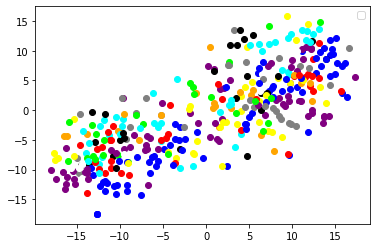

In [27]:
show_tsne_cls(src_features, src_cls_pred)

No handles with labels found to put in legend.


400


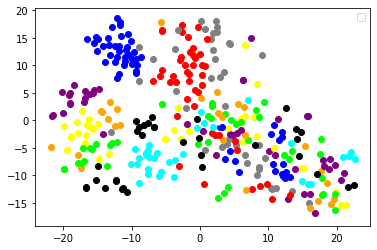

In [33]:
show_tsne_cls(trg_features, trg_cls_pred)

blue represent source domain / red represent target domain


No handles with labels found to put in legend.


400


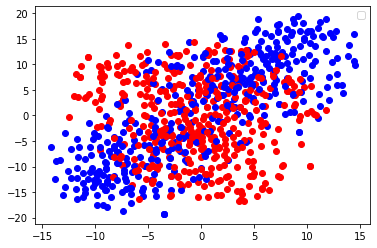

In [28]:
show_tsne_domain(src_features, trg_features)

Source Domain: mnist / Target Domain: usps

In [20]:
model_m_to_u = dann().to(device)
model_m_to_u.load_state_dict(torch.load("./check_point/dann_m_to_u.pth"))
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_m_to_u.parameters(), lr=lr, momentum = momentum)

In [ ]:
epochs = 25
gap = 50 # gap of batch between output
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_model(train_dl_mnist, train_dl_usps, model_m_to_u, adversarial_loss, 
                auxiliary_loss, optimizer, t, gap)

In [21]:
test(model_m_to_u, test_dl_mnist, test_dl_usps, 0.25)

scr_class_accuracy:85.00% trg_class_accuracy:73.49% scr_domain_accuracy:98.0% trg_domain_accuracy:97.6%


In [ ]:
torch.save(model_m_to_u.state_dict(), "./check_point/dann_m_to_u.pth")

In [40]:
alpha = 0.25
src_features, src_cls_pred, src_dm_pred = get_feature(model_m_to_u, test_dl_mnist, alpha)
trg_features, trg_cls_pred, trg_dm_pred = get_feature(model_m_to_u, test_dl_usps, alpha)

No handles with labels found to put in legend.


400


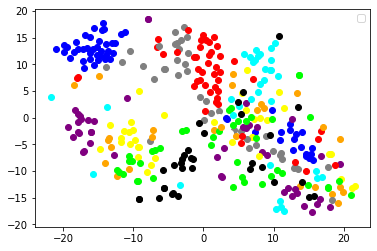

In [41]:
show_tsne_cls(src_features, src_cls_pred)

No handles with labels found to put in legend.


400


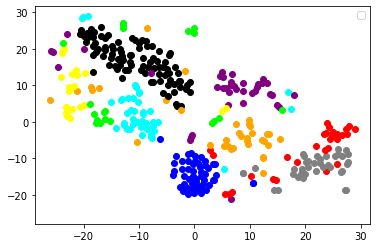

In [42]:
show_tsne_cls(trg_features, trg_cls_pred)

blue represent source domain / red represent target domain


No handles with labels found to put in legend.


400


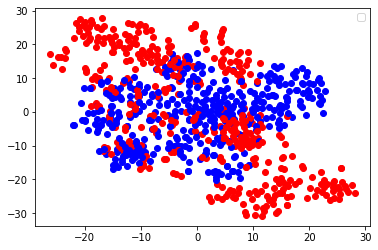

In [43]:
show_tsne_domain(src_features, trg_features)

Source Domain: usps / Target Domain: svhn

In [34]:
model_u_to_s = dann().to(device)
model_u_to_s.load_state_dict(torch.load("./check_point/dann_u_to_s.pth"))
# Loss functions
momentum = 9e-1
lr = 2e-4
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_u_to_s.parameters(), lr=lr, momentum = momentum)

In [ ]:
epochs = 15
gap = 50 # gap of batch between output
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_model(train_dl_usps, train_dl_svhn, model_u_to_s, adversarial_loss, 
                auxiliary_loss, optimizer, t, gap)

In [35]:
test(model_u_to_s, test_dl_usps, test_dl_svhn, 0.25)

scr_class_accuracy:97.01% trg_class_accuracy:22.33% scr_domain_accuracy:97.4% trg_domain_accuracy:98.7%


In [ ]:
torch.save(model_u_to_s.state_dict(), "./check_point/dann_u_to_s.pth")

In [44]:
alpha = 0.25
src_features, src_cls_pred, src_dm_pred = get_feature(model_u_to_s, test_dl_usps, alpha)
trg_features, trg_cls_pred, trg_dm_pred = get_feature(model_u_to_s, test_dl_svhn, alpha)

No handles with labels found to put in legend.


400


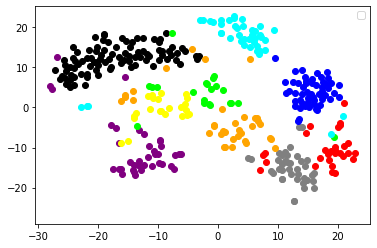

In [45]:
show_tsne_cls(src_features, src_cls_pred)

No handles with labels found to put in legend.


400


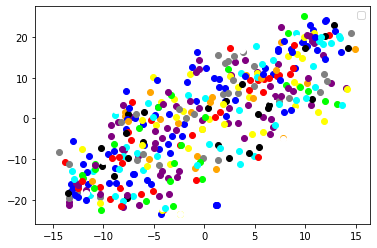

In [46]:
show_tsne_cls(trg_features, trg_cls_pred)

blue represent source domain / red represent target domain


No handles with labels found to put in legend.


400


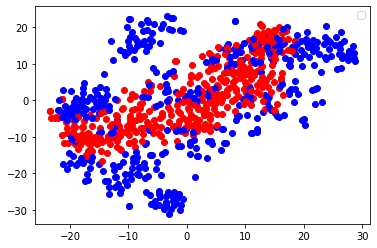

In [47]:
show_tsne_domain(src_features, trg_features)

Lower Bound: accuracy on target domain, train on source domain

In [48]:
model = dann()

In [49]:
for i in model.modules():
    print(i)

dann(
  (conv1): Sequential(
    (0): ConvTranspose2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=4800, out_features=2400, bias=True)
    (1): BatchNorm1d(2400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=2400, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
epochs = 1

Upper Bound: accuracy on target domain, train on target domain